# ALE PLot

- skip_exec: true


Accumulated local effects describe how features influence the prediction of a machine learning model on average. ALE plots are a faster and unbiased alternative to partial dependence plots (PDPs).

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import fetch_openml, load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from PyALE import ale
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)  # RGBA tuple with alpha=0
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)  # RGBA tuple with alpha=0


In [ ]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True, parser="pandas")

categorical_columns = ["pclass", "sex", "embarked"]
numerical_columns = ["age", "sibsp", "parch", "fare"]

X = X[categorical_columns + numerical_columns]
y = y.replace({"0": 0, "1": 1})

# Remove rows with missing values in X and y
missing_mask = X.isna().any(axis=1)

X = X[~missing_mask]
y = y[~missing_mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


In [ ]:
X


,pclass,sex,embarked,age,sibsp,parch,fare
0,1,female,S,29.0000,0,0,211.3375
1,1,male,S,0.9167,1,2,151.5500
2,1,female,S,2.0000,1,2,151.5500
3,1,male,S,30.0000,1,2,151.5500
4,1,female,S,25.0000,1,2,151.5500
...,...,...,...,...,...,...,...
1301,3,male,C,45.5000,0,0,7.2250
1304,3,female,C,14.5000,1,0,14.4542
1306,3,male,C,26.5000,0,0,7.2250
1307,3,male,C,27.0000,0,0,7.2250


In [ ]:
categorical_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)
rf.set_output(transform="pandas")
rf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['pclass', 'sex',
                                                   'embarked']),
                                                 ('num', SimpleImputer(),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare'])],
                                   verbose_feature_names_out=False)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
from sklearn.metrics import classification_report

test_preds = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, test_preds > 0.5))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80       155
           1       0.71      0.71      0.71       106

    accuracy                           0.77       261
   macro avg       0.76      0.76      0.76       261
weighted avg       0.77      0.77      0.77       261



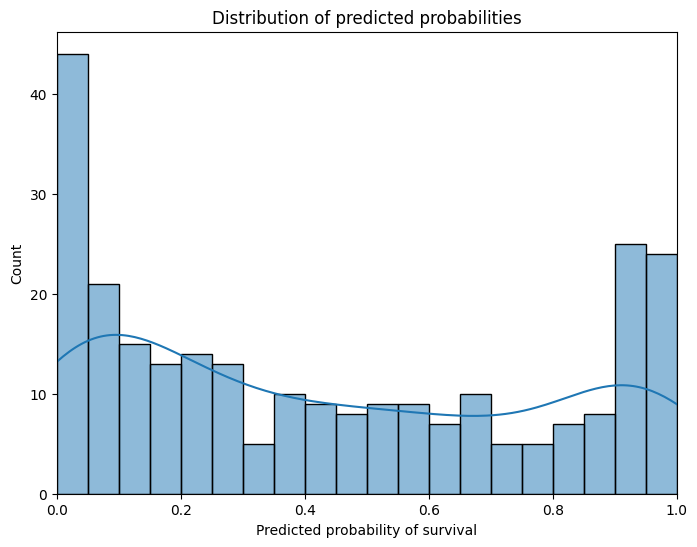

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(test_preds, bins=20, kde=True, ax=ax)
ax.set_xlabel("Predicted probability of survival")
ax.set_ylabel("Count")
ax.set_title("Distribution of predicted probabilities")
ax.set_xmargin(0)
plt.show()


In [ ]:
class clf_dummy:
    def predict(df):
        return rf.named_steps["classifier"].predict_proba(df)[:, 1]


In [ ]:
X_test_transformed = pd.DataFrame(
    rf.named_steps["preprocess"].transform(X_test),
    columns=rf.named_steps["preprocess"].get_feature_names_out(),
)


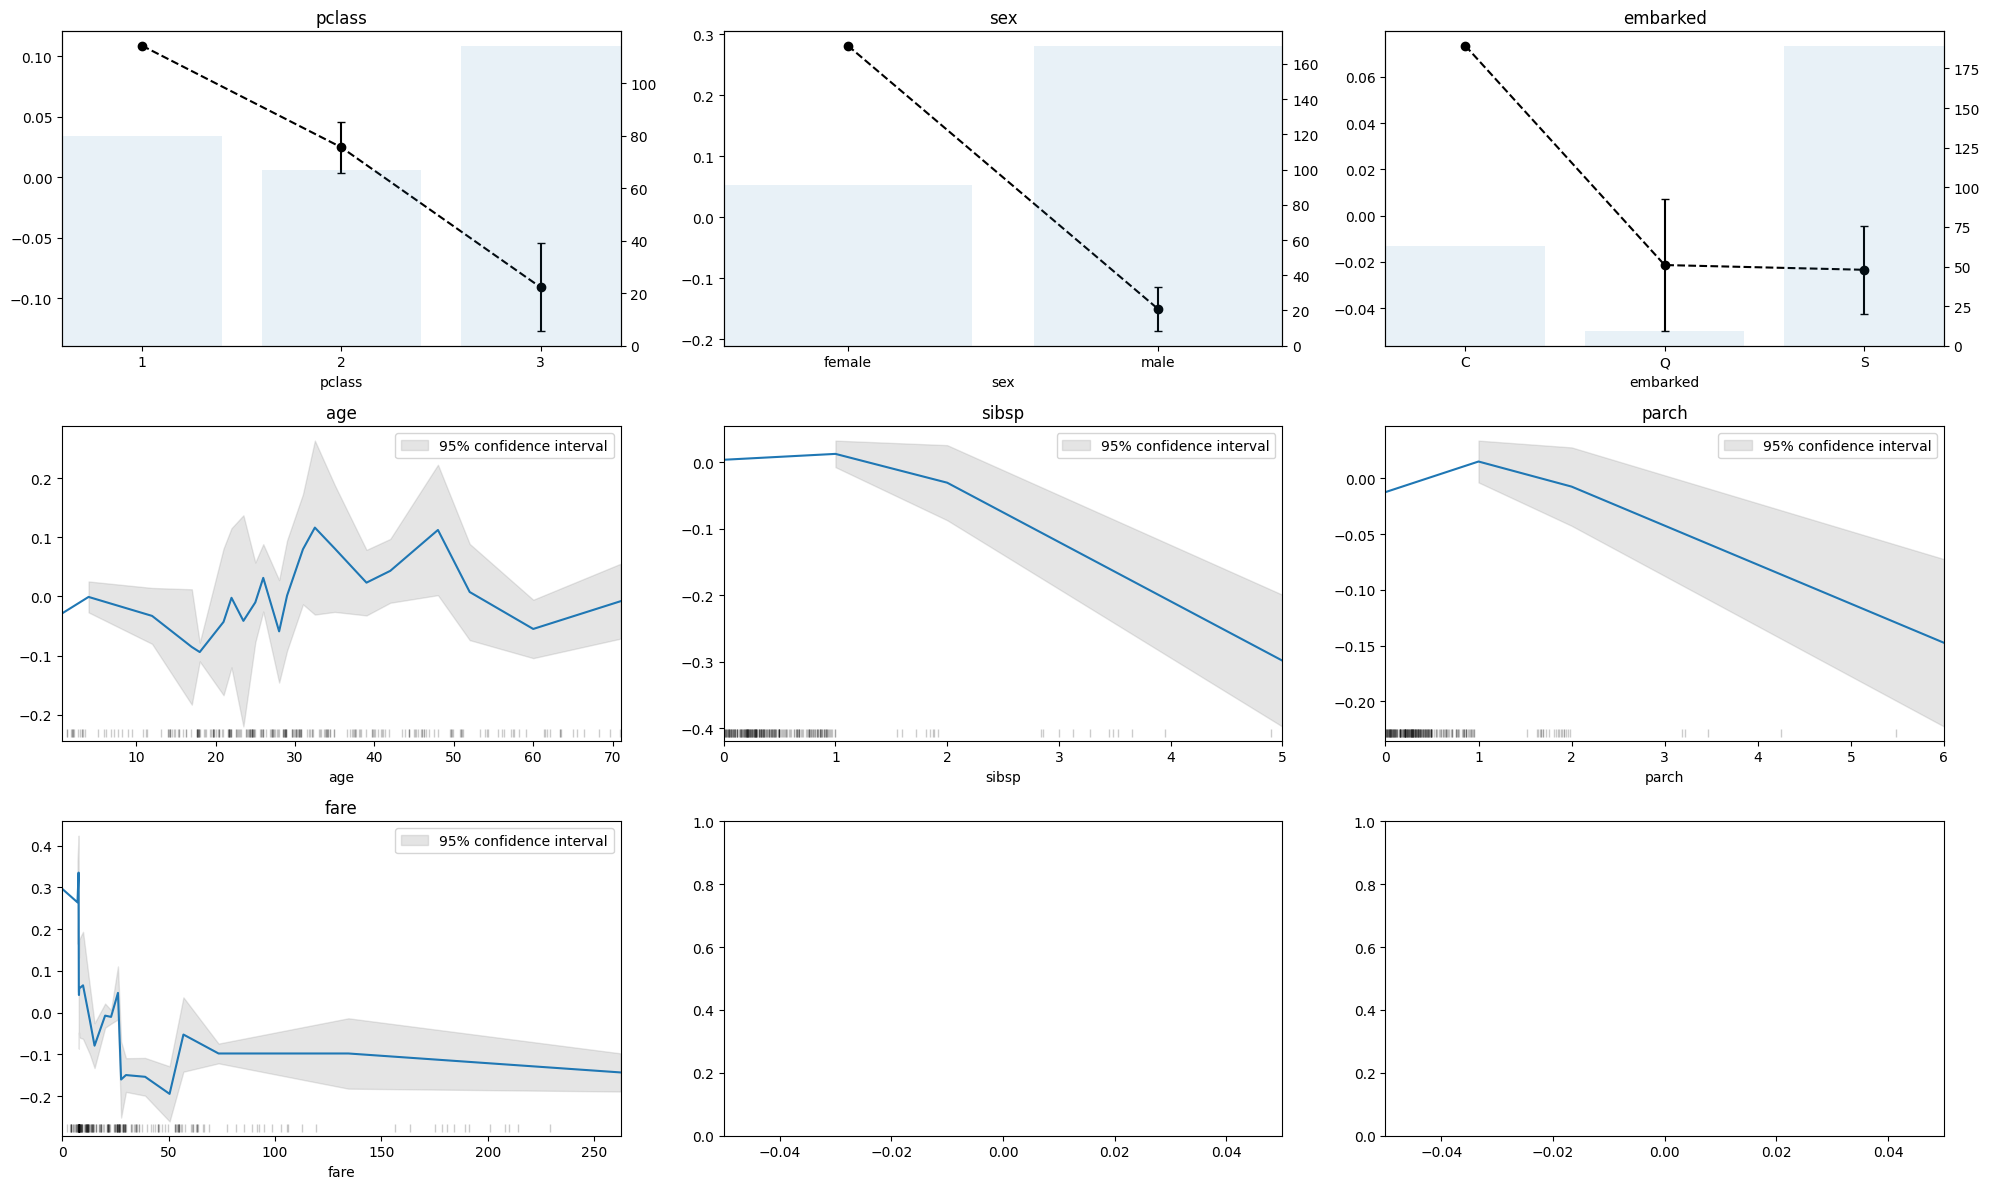

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
axes = axes.flatten()

for i, col in enumerate(X_test_transformed.columns):
    if col in numerical_columns:
        ale(X=X_test_transformed, model=clf_dummy, feature=[col], feature_type="continuous", fig=fig, ax=axes[i])
    elif col in categorical_columns:
        ale(X=X_test_transformed, model=clf_dummy, feature=[col], feature_type="discrete", fig=fig, ax=axes[i])
        category_names = rf.named_steps["preprocess"].transformers_[0][1].categories_[i]
        axes[i].set_xticks(axes[i].get_xticks())
        axes[i].set_xticklabels(category_names)
    else:
        continue

for ax in fig.axes:
    ax.set_title("")
    ax.tick_params(axis="y", labelcolor="black")
    ax.set_ylabel("")
    ax.set_xmargin(0)

for col, ax in zip(X_test_transformed.columns, fig.axes):
    ax.set_title(col)

plt.tight_layout()
plt.show()
